In [13]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

import tensorflow_datasets as tfds  # TFDS for MNIST
import tensorflow as tf             # TensorFlow operations

# from image_distribution_models import PixelCNN

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp
from encoding_information.image_utils import *
from encoding_information.bsccm_utils import *
from encoding_information.image_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


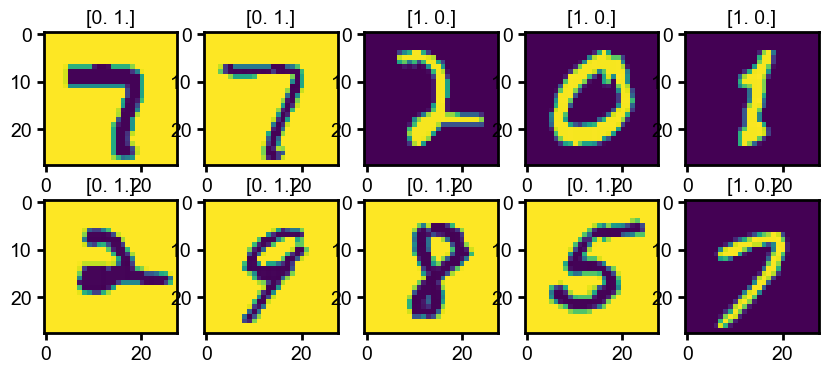

In [23]:
(mnist, mnist_labels), (_ , _) = tf.keras.datasets.mnist.load_data()
mnist[:mnist.shape[0]//2] = 255 - mnist[:mnist.shape[0]//2]
mnist = (mnist.astype(np.float32) / 255.) * 300 + 25 
# make labels for first half and second half of mnist
labels = np.concatenate([np.ones(len(mnist)//2), np.zeros(len(mnist)//2)])
# convert to one-hot
labels = np.eye(2)[labels.astype(np.int32)]
# shuffle
idx = onp.arange(len(mnist))
onp.random.shuffle(idx)
mnist = mnist[idx]
labels = labels[idx]

# plot some images with their lebels as titles
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    ax[0, i].imshow(mnist[i])
    ax[0, i].set_title(labels[i])
    ax[1, i].imshow(mnist[i+5])
    ax[1, i].set_title(labels[i+5])

images = mnist

In [32]:
from encoding_information.models.pixel_cnn import PixelCNN

pixel_cnn = PixelCNN()
pixel_cnn.fit(images, max_epochs=5, num_val_samples=100)
            #   , condition_vectors=labels)



Initial validation NLL: 12.03


Epoch 1: 100%|██████████| 100/100 [00:08<00:00, 11.59it/s]


Epoch 1: validation NLL: 1.75


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch 2: validation NLL: 1.70


Epoch 3: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch 3: validation NLL: 1.70


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 25.79it/s]


Epoch 4: validation NLL: 1.68


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 26.10it/s]


Epoch 5: validation NLL: 1.66


[12.02890396118164,
 1.7505236864089966,
 1.7036452293395996,
 1.6975774765014648,
 1.6757515668869019,
 1.6643569469451904]

In [28]:
num_samples = 20

# create 5 samples conditioned on one hot for class 0
conditioning_vecs = onp.zeros((num_samples, 2))
conditioning_vecs[0:num_samples//2, 0] = 1
conditioning_vecs[num_samples//2:, 1] = 1


samples = pixel_cnn.generate_samples(num_samples=num_samples, conditioning_vecs=conditioning_vecs)

Generating PixelCNN samples:   0%|          | 0/28 [00:00<?, ?it/s]2023-11-26 10:29:59.269022: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-11-26 10:29:59.269052: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[20,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f64[20,64,28,28]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-11-26 10:29:59.790390: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-11-26 10:29:59.790418: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[20,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f64[20,64,28,28]{3,2,1,0},

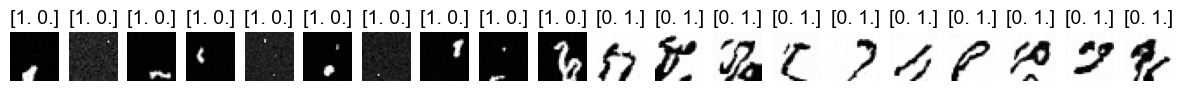

In [29]:
# plot samples
fig, axs = plt.subplots(1, num_samples, figsize=(15, 15))
for i in range(num_samples):
    axs[i].imshow(samples[i], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(conditioning_vecs[i])